In [1]:
from collections import defaultdict
import json
import numpy as np
import os
import pandas as pd

In [2]:
import plotting_utils
import matplotlib.pyplot as plt
import seaborn as sns
import pylab

plotting_utils.setup_plotting_params()

In [3]:
RUNDIR = "../benchmark_output/runs/v7_subset"

In [4]:
num_gpus = {
    "openai_davinci": 8,
    "ai21_j1-large": 1,
    "ai21_j1-grande": 1,
    "ai21_j1-jumbo": 8,
    "cohere_xlarge-20220609": 4,
    "microsoft_TNLGv2_530B": 24,
    "anthropic_stanford-online-all-v4-s3": 4,
    "together_gpt-j-6b": 1,
    "together_yalm": 4,
    "together_bloom": 8,
}
colors = {
    "openai_davinci": 'blue',
    "ai21_j1-large": 'pink',
    "ai21_j1-grande": 'purple',
    "ai21_j1-jumbo": 'grey',
    "cohere_xlarge-20220609": 'green',
    "microsoft_TNLGv2_530B": 'black',
    "anthropic_stanford-online-all-v4-s3": 'magenta',
    "together_gpt-j-6b": 'orange',
    "together_yalm": 'skyblue',
    "together_bloom": 'red',
}
model_configs = {
    "openai_davinci": (12288, 96),
    "ai21_j1-large": (4096, 32),
    "ai21_j1-grande": (5120, 50),
    "ai21_j1-jumbo": (13824, 76),
    "cohere_xlarge-20220609": (8192, 64),
    "anthropic_stanford-online-all-v4-s3": (8192, 64),
    "microsoft_TNLGv2_530B": (20480, 105),
    "together_gpt-j-6b": (4096, 28),
    "together_yalm": (10240, 80),
    "together_bloom": (14336, 70),
}
model_sizes = {
    "openai_davinci": 175,
    "ai21_j1-large": 7.5,
    "ai21_j1-grande": 17,
    "ai21_j1-jumbo": 178,
    "cohere_xlarge-20220609": 52,
    "anthropic_stanford-online-all-v4-s3": 52,
    "microsoft_TNLGv2_530B": 530,
    "together_gpt-j-6b": 6,
    "together_yalm": 100,
    "together_bloom": 176,
}
names = {
    "openai_davinci": 'OpenAI/davinci',
    "ai21_j1-large": 'AI21/J1-Large v1',
    "ai21_j1-grande": 'AI21/J1-Grande v1',
    "ai21_j1-jumbo": 'AI21/J1-Jumbo v1',
    "cohere_xlarge-20220609": 'Cohere/XL v20220609',
    "anthropic_stanford-online-all-v4-s3": 'Anthropic/v4-s3',
    "microsoft_TNLGv2_530B": 'Microsoft+NV/TNLG v2',
    "together_gpt-j-6b": 'EleutherAI/GPT-J',
    "together_yalm": 'Yandex/YALM',
    "together_bloom": 'BigScience/BLOOM',
}
# Using AWS price: https://aws.amazon.com/ec2/pricing/on-demand/.
# Note that AWS only offers 8-A100 instances, so dividing by 8 here.
cost_of_a100_gpu_per_hour = 4.096
cost_of_v100_gpu_per_hour = 3.06

In [5]:
class Run:
    def __init__(self, key):
        scenario, args = key.split(":")
        args = args.split(",")
        self.scenario = scenario
        for arg in args:
            k, v = arg.split("=")
            setattr(self, k, v)
            
        self.runtimes = []
        self.idealized_runtimes = []
        self.denoised_runtimes = []
        self.idealized_costs = []
        self.exact_match = []
        self.num_prompt_tokens = []
        self.num_output_tokens = []
        self.flops = []
        with open(os.path.join(RUNDIR, key, "per_instance_stats.json"), "r") as f:
            all_instance_stats = json.load(f)
            for per_instance_stats in all_instance_stats:
                stats = per_instance_stats["stats"]
                for stat in stats:
                    if stat["name"]["name"] == "inference_runtime":
                        self.runtimes.append(float(stat["mean"]))
                    elif stat["name"]["name"] == "inference_denoised_runtime":
                        self.denoised_runtimes.append(float(stat["mean"]))
                    elif stat["name"]["name"] == "inference_idealized_runtime":
                        if stat["count"] > 0:
                            self.idealized_runtimes.append(float(stat["mean"]))
                            if self.model in num_gpus:
                                self.idealized_costs.append(
                                    self.idealized_runtimes[-1] * cost_of_a100_gpu_per_hour *
                                    num_gpus[self.model] / 36.0)
                    elif stat["name"]["name"] == "exact_match":
                        self.exact_match.append(stat["mean"])
                    elif stat["name"]["name"] == "num_prompt_tokens":
                        self.num_prompt_tokens.append(stat["mean"])
                    elif stat["name"]["name"] == "num_output_tokens":
                        self.num_output_tokens.append(stat["mean"])
        for (num_prompt_tokens, num_output_tokens) in zip(
            self.num_prompt_tokens, self.num_output_tokens):
            if self.model not in model_configs:
                self.flops.append(None)
            else:
                (h, num_layers) = model_configs[self.model]
                flops = 24 * h**2 * (num_prompt_tokens + num_output_tokens - 1) * num_layers
                self.flops.append(flops)

In [6]:
runs = []
for run_key in os.listdir(RUNDIR):
    if (
        run_key.startswith("mmlu:subject=college_chemistry")
        or run_key.startswith("imdb")
        or run_key.startswith("raft:subset=terms_of_service")
        or run_key.startswith("boolq")
    ):
        if "only_contrast" in run_key:
            continue
        run = Run(run_key)
        if run.model not in model_configs:
            continue
        runs.append(Run(run_key))

In [7]:
runs_grouped_by_scenario = defaultdict(list)
for run in runs:
    if run.scenario == "mmlu":
        scenario = f"mmlu:subject={run.subject}"
    elif run.scenario == "raft":
        scenario = f"raft:subset={run.subset}"
    elif run.scenario == "natural_qa":
        scenario = f"natural_qa:model={run.mode}"
    elif run.scenario == "civil_comments":
        scenario = f"civil_comments:demographic={run.demographic}"
    elif run.scenario == "babi_qa":
        scenario = f"babi_qa:task={run.task}"
    elif run.scenario == "entity_matching":
        scenario = f"entity_matching:dataset={run.dataset}"
    elif run.scenario == "synthetic_reasoning":
        scenario = f"synthetic_reasoning:mode={run.mode}"
    elif run.scenario == "imdb" or run.scenario == 'boolq':
        if getattr(run, 'only_contrast', None) is None:
            scenario = run.scenario
        else:
            scenario = f"{run.scenario}:only_contrast={getattr(run, 'only_contrast')}"
    else:
        scenario = run.scenario
    runs_grouped_by_scenario[scenario].append(run)

In [8]:
def get_rankings_per_scenario(runs_grouped_by_scenario, log_runtimes=False):
    rankings_per_scenario = {}
    for scenario in runs_grouped_by_scenario:
        scores = []
        for run in runs_grouped_by_scenario[scenario]:
            accuracy = np.mean(run.exact_match)
            if len(run.exact_match) == 0 or len(run.idealized_runtimes) == 0:
                continue
            if log_runtimes:
                idealized_runtime = np.log(np.mean(run.idealized_runtimes))
            else:
                idealized_runtime = np.mean(run.idealized_runtimes) 
            scores.append((run.model, accuracy / idealized_runtime))
        scores.sort(key=lambda x: x[1], reverse=True)
        rankings_per_scenario[scenario] = scores
    return rankings_per_scenario

In [9]:
def get_numerical_rankings_per_scenario(rankings_per_scenario):
    all_models = set()
    for scenario in rankings_per_scenario:
        for (model, score) in rankings_per_scenario[scenario]:
            all_models.add(model)
    model_ids = {model: i for i, model in enumerate(sorted(all_models))}
    numerical_rankings_per_scenario = {}
    for scenario in rankings_per_scenario:
        numerical_rankings_per_scenario[scenario] = [
            model_ids[model] for model, _ in rankings_per_scenario[scenario]
        ]
    return model_ids, numerical_rankings_per_scenario

In [10]:
def get_per_model_ranks(model_ids, numerical_rankings_per_scenario):
    rank_per_model = defaultdict(list)
    for model in model_ids:
        for scenario in numerical_rankings_per_scenario:
            rank_per_model[model].append(
                numerical_rankings_per_scenario[scenario].index(model_ids[model])
            )
    rank_stats = []
    for model in rank_per_model:
        rank_stats.append(
            (
                model,
                np.min(rank_per_model[model]),
                np.mean(rank_per_model[model]),
                np.max(rank_per_model[model]),
                np.std(rank_per_model[model]),
            )
        )
    rank_stats.sort(key=lambda x: (x[2], x[4]))
    
    return rank_per_model, rank_stats

In [11]:
def plot_ranks(
    numerical_rankings_per_scenario, rank_per_model, rank_stats, log_runtimes=False
):
    fig = pylab.figure(figsize=(7.5, 4))
    figlegend = pylab.figure(figsize=(7.5, 1))

    ax = fig.add_subplot(111)
    # plt.figure(figsize=(7.5, 4))
    labels = ["RAFT", "BoolQ", "IMDB", "MMLU"]
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"][:4]
    markers = ["o", "^", "s", "P"]
    lines = []

    for i, data in enumerate(rank_stats[::-1]):
        model = data[0]
        for j, scenario in enumerate(list(numerical_rankings_per_scenario.keys())):
            if i == len(rank_stats) - 1:
                lines.append(
                    ax.scatter(
                        rank_per_model[model][j] + 1,
                        i,
                        label=labels[j],
                        marker=markers[j],
                        color=colors[j],
                    )
                )
            else:
                lines.append(
                    ax.scatter(
                        rank_per_model[model][j] + 1,
                        i,
                        marker=markers[j],
                        color=colors[j],
                    )
                )
    ax.set_yticks(list(range(len(rank_stats))))
    ax.set_yticklabels([names[data[0]] for data in rank_stats[::-1]])
    if log_runtimes:
        ax.set_xlabel("Rank (Accuracy / log(Idealized runtime))")
    else:
        ax.set_xlabel("Rank (Accuracy / Idealized runtime)")
    ax.set_xticks(list(range(1, len(rank_stats) + 1)))

    figlegend.legend(
        lines,
        labels,
        loc="center",
        frameon=False,
        ncol=len(labels),
        columnspacing=None,
        labelspacing=None,
    )

    if log_runtimes:
        output_filename = (
            "../figures/efficiency_vs_capability/ranks/accuracy_over_log_runtime.pdf"
        )
    else:
        output_filename = (
            "../figures/efficiency_vs_capability/ranks/accuracy_over_runtime.pdf"
        )
    fig.savefig(output_filename, bbox_inches="tight")

    figlegend.savefig(
        "../figures/efficiency_vs_capability/ranks/legend.pdf", bbox_inches="tight"
    )

mmlu:subject=college_chemistry
[('ai21_j1-large', 6.747977150275187), ('together_gpt-j-6b', 4.3678433075541365), ('anthropic_stanford-online-all-v4-s3', 3.25850331398548), ('ai21_j1-grande', 2.3601756283942104), ('cohere_xlarge-20220609', 1.6806600198055053), ('ai21_j1-jumbo', 1.398170317908225), ('openai_davinci', 1.3077704273194084), ('together_bloom', 0.9577034720213218), ('together_yalm', 0.7403479592375024), ('microsoft_TNLGv2_530B', 0.5567876551558035)]

boolq
[('ai21_j1-large', 5.862780180991339), ('together_gpt-j-6b', 3.6616374649664993), ('anthropic_stanford-online-all-v4-s3', 3.487377600080395), ('ai21_j1-grande', 3.1218834209555335), ('cohere_xlarge-20220609', 2.9568862280626362), ('openai_davinci', 1.8000739879279313), ('ai21_j1-jumbo', 1.648118344095308), ('together_bloom', 1.078997984723028), ('microsoft_TNLGv2_530B', 0.6425505833528687), ('together_yalm', 0.5211599560713617)]

raft:subset=terms_of_service
[('ai21_j1-grande', 3.6068160699545118), ('cohere_xlarge-20220609'

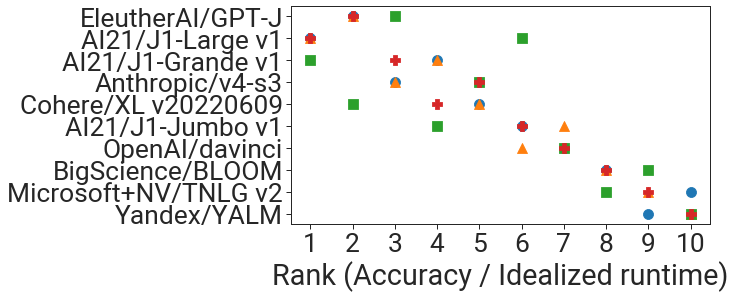

<Figure size 540x72 with 0 Axes>

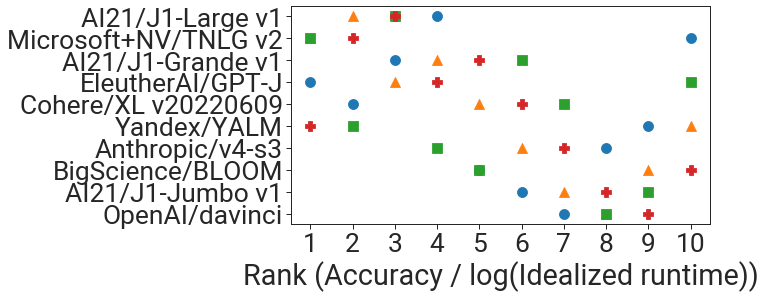

<Figure size 540x72 with 0 Axes>

In [12]:
for log_runtimes in [False, True]:
    rankings_per_scenario = get_rankings_per_scenario(
        runs_grouped_by_scenario, log_runtimes
    )
    for scenario in rankings_per_scenario:
        print(scenario)
        print(rankings_per_scenario[scenario])
        print()

    model_ids, numerical_rankings_per_scenario = get_numerical_rankings_per_scenario(
        rankings_per_scenario
    )
    for scenario in numerical_rankings_per_scenario:
        print(scenario)
        print(numerical_rankings_per_scenario[scenario])
        print()

    rank_per_model, rank_stats = get_per_model_ranks(
        model_ids, numerical_rankings_per_scenario
    )

    for i, (model, min_rank, mean_rank, max_rank, std) in enumerate(rank_stats):
        print(
            f"{i}) model={model}, "
            f"min rank = {min_rank}, "
            f"mean rank={mean_rank}, "
            f"max rank={max_rank}, "
            f"std={std}"
        )
        
    plot_ranks(numerical_rankings_per_scenario, rank_per_model, rank_stats, log_runtimes)